# rSLDS - Hangry Mice

This notebook allows for 2-dimensional models

## Set up environment

### Packages and helper functions

In [155]:
# # Save learned model
# # After training, we use pickle to save the trained rSLDS model

# rslds_model = rslds_lem
# file_rslds = open('C:/Users/adity/Dropbox/Code/rSLDS_dynamical_systems/State_Discovery/Results/feeding_VMHvl/M2/low_dim_v1/rslds_model.obj', 'wb')
# pickle.dump(rslds_model, file_rslds)

# mdic = {"cont_states": xhat_lem, "label": "Mouse_1"}
# savemat("C:/Users/adity/Dropbox/Code/rSLDS_dynamical_systems/State_Discovery/Results/feeding_VMHvl/M2/low_dim_v1/cont_states.mat", mdic)

# mdic = {"discrete_state": zhat_lem, "label": "Mouse_1"}
# savemat("C:/Users/adity/Dropbox/Code/rSLDS_dynamical_systems/State_Discovery/Results/feeding_VMHvl/M2/low_dim_v1/discrete_states.mat", mdic)

# mdic = {"factor_weights": rslds_lem.emissions.Cs, "label": "Mouse_1"}
# savemat("C:/Users/adity/Dropbox/Code/rSLDS_dynamical_systems/State_Discovery/Results/feeding_VMHvl/M2/low_dim_v1/factor_weights.mat", mdic)

In [156]:
# # Load trained models

# file_rslds = open('C:/Users/adity/Dropbox/Code/rSLDS_dynamical_systems/State_Discovery/Results/feeding_VMHvl/M2/low_dim_v1/rslds_model.obj', 'rb') 
# rslds_lem = pickle.load(file_rslds)

# cont_states = loadmat('C:/Users/adity/Dropbox/Code/rSLDS_dynamical_systems/State_Discovery/Results/feeding_VMHvl/M2/low_dim_v1/cont_states.mat');
# disc_states = loadmat('C:/Users/adity/Dropbox/Code/rSLDS_dynamical_systems/State_Discovery/Results/feeding_VMHvl/M2/low_dim_v1/discrete_states.mat');

# xhat_lem = cont_states['cont_states']
# zhat_lem = disc_states['discrete_state']

# zhat_lem = zhat_lem[0,:]

In [156]:
# Packages, Plotting & Helper Functions: -----
import sklearn
import os
import pickle
import copy

import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(12345)

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
# %matplotlib notebook

import ssm
from ssm.util import random_rotation, find_permutation

import seaborn as sns

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown",
               "goldenrod"]
colors = sns.xkcd_palette(color_names)
sns.set_style("white")
sns.set_context("talk")

# Helper functions for plotting results
def plot_trajectory(z, x,a1,a2,ax=None, ls="-"):
    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    for start, stop in zip(zcps[:-1], zcps[1:]):
        ax.plot(x[start:stop + 1, a1],
                x[start:stop + 1, a2],
                lw=1, ls=ls,
                color=colors_state_dynamics[z[start] % len(colors_state_dynamics)],
                alpha=1.0)
    return ax

def plot_observations(z, y, ax=None, ls="-", lw=1):

    zcps = np.concatenate(([0], np.where(np.diff(z))[0]+1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    T, N = y.shape
    t = np.arange(T)
    for n in range(N):
        for start, stop in zip(zcps[:-1], zcps[1:]):
            ax.plot(t[start:stop + 1], y[start:stop + 1, n],
                    lw=lw, ls=ls,
                    color=colors[z[start] % len(colors)],
                    alpha=1.0)
    return ax

def plot_trajectory_beh(z, x, a1, a2, ax=None, alpha=1, ls="-"):
    zcps = np.concatenate(([0], np.where(np.diff(z))[0]+1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    for start, stop in zip(zcps[:-1], zcps[1:]):
        ax.plot(x[start:stop + 1, a1],
                x[start:stop + 1, a2],
                lw=1, ls=ls,
                color=
                colors_beh[z[start] % len(colors_beh)],
                alpha=alpha)
    return ax

def plot_most_likely_dynamics(model,
    xlim=(-4, 4), ylim=(-3, 3), nxpts=20, nypts=20,
    alpha=0.8, ax=None, figsize=(3, 3)):
    
    K = model.K
    assert model.D == 2
    x = np.linspace(*xlim, nxpts)
    y = np.linspace(*ylim, nypts)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    # Get the probability of each state at each xy location
    z = np.argmax(xy.dot(model.transitions.Rs.T) + model.transitions.r, axis=1)

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

    for k, (A, b) in enumerate(zip(model.dynamics.As, model.dynamics.bs)):
        dxydt_m = xy.dot(A.T) + b - xy

        zk = z == k
        if zk.sum(0) > 0:
            ax.quiver(xy[zk, 0], xy[zk, 1],
                      dxydt_m[zk, 0], dxydt_m[zk, 1],
                      color=colors_state_dynamics[k % len(colors_state_dynamics)], alpha=alpha)

    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    plt.tight_layout()

    return ax

def plot_most_likely_dynamics_state(model,
    xlim=(-4, 4), ylim=(-3, 3), nxpts=20, nypts=20,
    alpha=0.8, ax=None, figsize=(3, 3)):
    
    K = model.K
    assert model.D == 2
    x = np.linspace(*xlim, nxpts)
    y = np.linspace(*ylim, nypts)
    X, Y = np.meshgrid(x, y)
    xy = np.column_stack((X.ravel(), Y.ravel()))

    # Get the probability of each state at each xy location
    z = np.argmax(xy.dot(model.transitions.Rs.T) + model.transitions.r, axis=1)

    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)

    for k, (A, b) in enumerate(zip(model.dynamics.As, model.dynamics.bs)):
        dxydt_m = xy.dot(A.T) + b - xy

        if k == 2:
            varAs = model.dynamics.As
            varbs = model.dynamics.bs
            dxydt_m = xy.dot(varAs[1].T) + varbs[1] - xy

            zk = z == k
            if zk.sum(0) > 0:
                ax.quiver(xy[zk, 0], xy[zk, 1],
                        dxydt_m[zk, 0], dxydt_m[zk, 1],
                        color=colors_state_dynamics[1 % len(colors_state_dynamics)], alpha=alpha)
 
        else:
                
            zk = z == k
            if zk.sum(0) > 0:
                ax.quiver(xy[zk, 0], xy[zk, 1],
                        dxydt_m[zk, 0], dxydt_m[zk, 1],
                        color=colors_state_dynamics[k % len(colors_state_dynamics)], alpha=alpha)


    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    plt.tight_layout()

    return ax

def plot_state_pie(zhat_lem,model, statedatapy,figsize=(55,10)):

    fig = plt.figure(figsize=figsize)

    beh_labels = ["None", "Attack","Sniff-Attack","Dom-Mount","Sniff-Alone"]
    c = 1  # initialize plot counter

    for i in range(0,model.K):
        x = np.where(zhat_lem == i)
        state_vals = statedatapy[x]
        state_vals= np.bincount(state_vals)
        plt.subplot(1, model.K, c)
#         plt.pie(state_vals, autopct="%1.0f%%", labels=beh_labels[0:state_vals.size], pctdistance=0.55,labeldistance=1.1, colors = colors_beh)
        plt.pie(state_vals, autopct="%1.0f%%", pctdistance=1.3,labeldistance=1.1, colors = colors_beh)

        #         pie_beh[0][:].set_alpha
        #draw circle
        centre_circle = plt.Circle((0,0),0.70,fc='white')
        fig = plt.gcf()
        fig.gca().add_artist(centre_circle)

        plt.title('State '+ str(i+1)+ ' ' + color_names[i])
        c = c + 1

In [157]:
# More plotting functions from sLDS ----- 
from scipy.io import loadmat
from scipy.io import savemat
import autograd.numpy as np
import autograd.numpy.random as npr

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns

sns.set_style("white")
sns.set_context("talk")

color_names = ["red",
               "windows blue",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)
cmap = ListedColormap(colors)

import ssm
from ssm.util import random_rotation, find_permutation
from ssm.plots import plot_dynamics_2d

save_figures = False

color_names_beh = ["black",
                   "white",
                   "red",
                   "amber",
                   "windows blue",
                   "faded green"]

colors_beh =  sns.xkcd_palette(color_names_beh)
cmap_limited_beh = ListedColormap(color_names_beh)

### Model and data

In [158]:
# Set the parameters of rSLDS -----
K = 3 # number of discrete states
D_obs = 2  # number of observed dimensions
D_latent = 2 # number of latent dimensions

In [159]:
# Import data, states: annotations, neural data: ca traces
# Behavior index:
# 0: no beh, 1: attack, 2: eating, 3: food_sniff, 4: sniffM
# neuraldata is a NxT matrix of calcium activity
vmhdata = loadmat('data/EG1-4_fasted_rSLDS.mat')
neuraldata = np.transpose(vmhdata['neuralDataPreprocessed'])
statedata = vmhdata['collapsedBehaviorData']

statedatapy = statedata[0,:]

In [160]:
cluster_labels_fasted = np.array([0, 0, 3, 3, 3, 3, 0, 0, 0, 0, 0, 3, 3, 4, 4, 4, 0, 4, 4, 3, 2, 2,
                                  2, 1, 2, 0, 0, 0, 3, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1,
                                  1, 1, 0, 0, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 1, 1, 3, 1, 2, 2,
                                  1, 0, 2, 2, 3, 1, 2])

In [161]:
neuraldata_male = neuraldata[:, np.isin(cluster_labels_fasted, [1, 2])]

## rSLDS

In [162]:
# Fit model using Laplace-EM (without inputs)
# l2_penalty params act as regularizers for the factor analysis and AR-HMM steps in rSLDS
rSLDSdata = neuraldata_male
D_obs = rSLDSdata.shape[1]
print("Fitting SLDS with Laplace-EM")

rslds = ssm.SLDS(D_obs, K, D_latent,
                 transitions="recurrent_only",
                 dynamics="gaussian",
                 emissions="gaussian",
                 single_subspace=True,
                 dynamics_kwargs=dict(l2_penalty_A=100),
                 transitions_kwargs=dict(l2_penalty=500)
                 )

rslds.initialize(rSLDSdata) # Not sure what this does

# Fit the model using Laplace-EM with a structured variational posterior
# alpha term weights the evidence for each iteration of the model

q_elbos_lem, q_lem = rslds.fit(rSLDSdata, method="laplace_em", 
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=150, alpha=0.5)

Fitting SLDS with Laplace-EM


  0%|          | 0/150 [00:00<?, ?it/s]

In [163]:
# Save learned model
file_rslds = open('model/rslds_model_EG1-4_fasted_malecluster.obj', 'wb')
pickle.dump(rslds, file_rslds)

In [164]:
# Load learned model
# file_rslds = open('model/rslds_model_EG1-4_fasted_malecluster.obj', 'rb') 
# rslds = pickle.load(file_rslds)

In [165]:
# Find the permutation that matches the true and inferred states
# Get the posterior mean of the continuous states
xhat_lem = q_lem.mean_continuous_states[0]
# rslds.permute(find_permutation(statedatapyfsubfl, rslds.most_likely_states(xhat_lem, neuraldatasub)))
zhat_lem = rslds.most_likely_states(xhat_lem, rSLDSdata)

# store rslds
rslds_lem = copy.deepcopy(rslds)

### ELBO

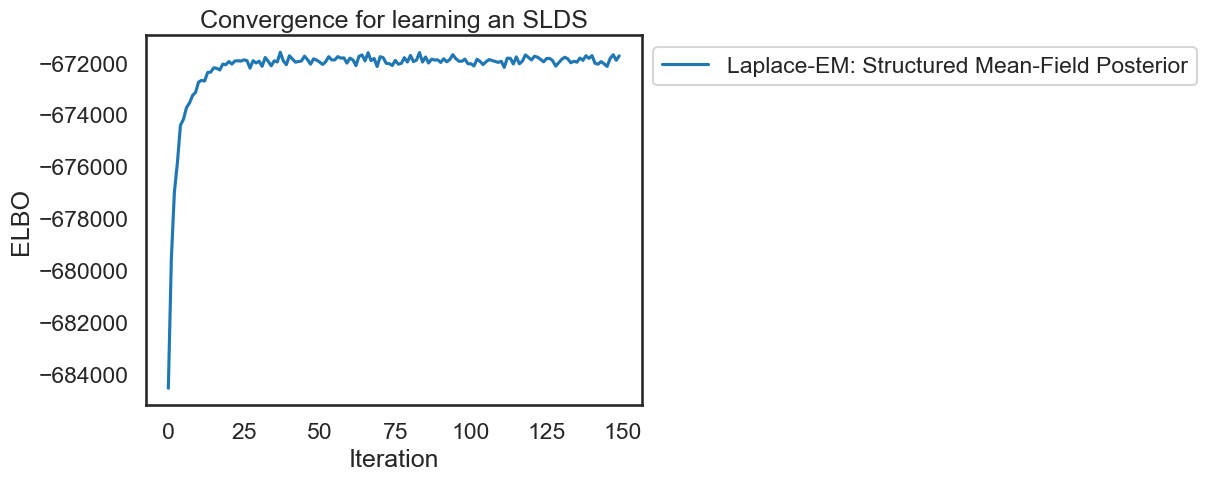

In [166]:
# Plot ELBO (Log Likelihood) 
# plt.plot(q_elbos_bbvi, label="BBVI")

plt.plot(q_elbos_lem[1:], label="Laplace-EM: Structured Mean-Field Posterior")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.title("Convergence for learning an SLDS")
plt.show()

### State transitions

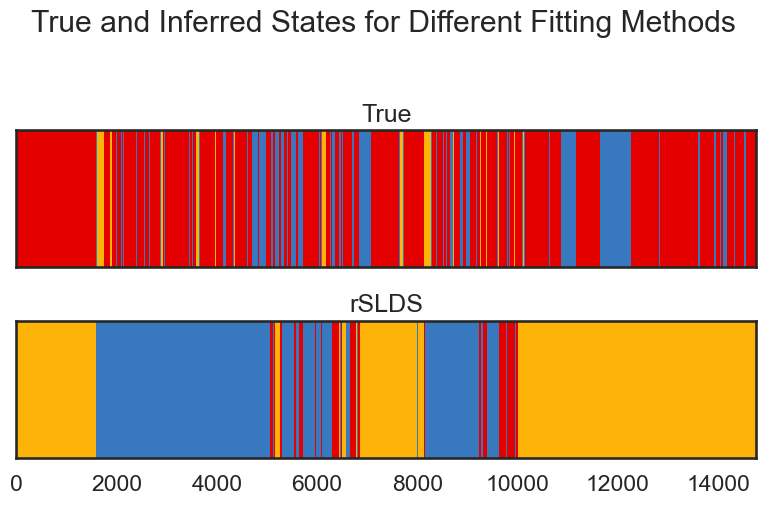

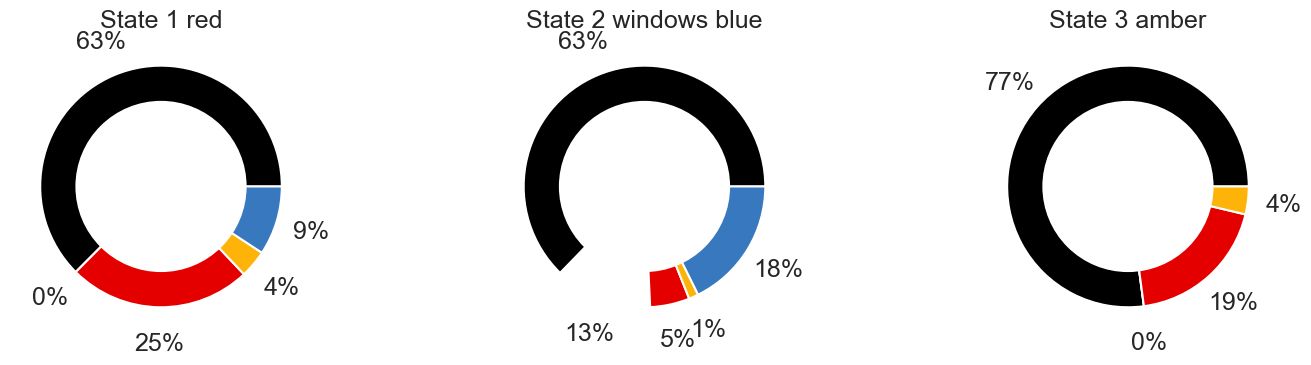

In [167]:
# Plot the true and inferred states
# true states refer to the behs given by the yser
cmap_limited = ListedColormap(colors[0:K])

titles = ["True", "rSLDS", "SVI with Structured MF", "SVI with MF"]
states_list = [statedatapy, zhat_lem]
fig, axs = plt.subplots(2,1, figsize=(8,5))
for (i, ax, states) in zip(range(len(axs)), axs, states_list):
    ax.imshow(states[None,:], aspect="auto", cmap=cmap_limited)
    ax.set_yticks([])
    ax.set_title(titles[i])
    if i < (len(axs) - 1):
        ax.set_xticks([])

plt.suptitle("True and Inferred States for Different Fitting Methods", va="baseline")
plt.tight_layout()

plot_state_pie(zhat_lem, rslds_lem, statedatapy, figsize=(15,4))
plt.tight_layout()

# plt.savefig("~path/state_comp.svg")
# mdic = {"discrete_state": zhat_lem, "label": "Mouse_2"}
# savemat("~path/discrete_states.mat", mdic)

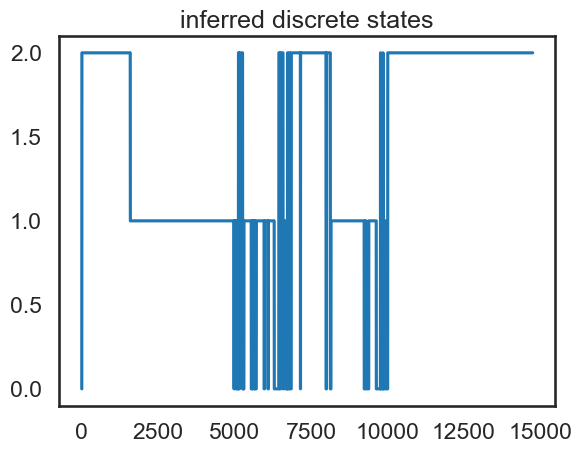

In [168]:
# Plot the learned discrete states
plt.title("inferred discrete states")
plt.plot(zhat_lem)

[51.83580176 51.83580176]
[70.01956231 70.01956231]
[10.24087815 86.6636218 ]


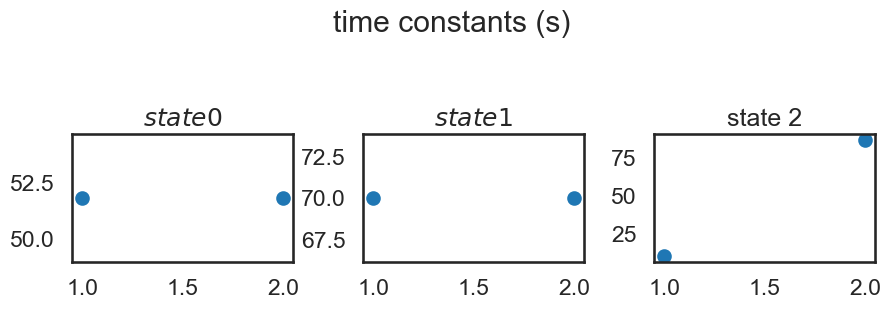

In [169]:
# Plot time constants (from eigenvalues of dynamics matrix)
title_str = ["$state 0$", "$state 1$", "state 2"]

fig, axs = plt.subplots(1,rslds_lem.K, figsize=(9,3))
for (d, ax) in enumerate(axs):
    w, v = np.linalg.eig(rslds_lem.dynamics.As[d,:,:])
    time_const_w = (np.abs(1/np.log(np.abs(w))))/10
    x_pos = range(1,3)
    ax.scatter(x_pos, time_const_w)
    print(time_const_w)
    ax.set_title(title_str[d])

plt.suptitle("time constants (s)", va="baseline")
plt.tight_layout() 

### Latent factors

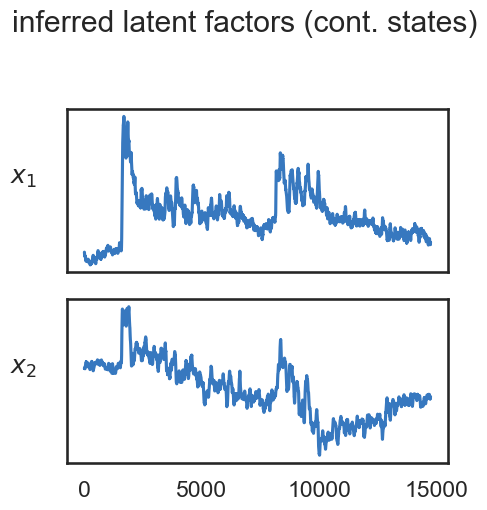

In [170]:
# Plot continous states (latent factors) 
title_str = ["$x_1$", "$x_2$"]
fig, axs = plt.subplots(2,1, figsize=(5,5))
for (d, ax) in enumerate(axs):
    ax.plot( -xhat_lem[:,d] + 4 * d, '-', color=colors[1], label="Laplace-EM" if d==0 else None)
    ax.set_yticks([])
    ax.set_title(title_str[d], loc="left", y=0.5, x=-0.15)
axs[0].set_xticks([])
# axs[0].legend(loc="upper right")

plt.suptitle("inferred latent factors (cont. states)", va="bottom")
plt.tight_layout()

In [186]:
# Specify colors for plotting behaviors
color_names_beh = ["white",
                   "red",
                   "orange",
                   "faded green",
                   "windows blue"]
colors_beh =  sns.xkcd_palette(color_names_beh[0:])
cmap_limited_beh = ListedColormap(colors_beh)

[]

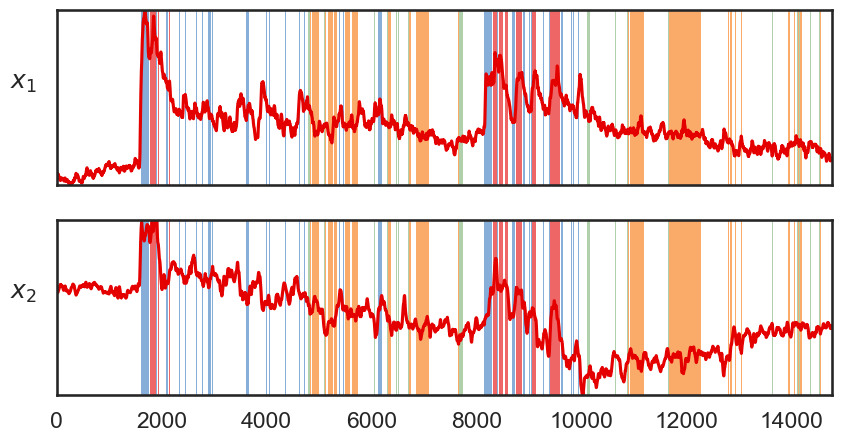

In [188]:
title_str = ["$x_1$", "$x_2$"]
fig, axs = plt.subplots(2,1, figsize=(10,5))
for (d, ax) in enumerate(axs):
    ax.plot(sklearn.preprocessing.minmax_scale(xhat_lem[:,d], feature_range=(-0.5,0.5)), '-', color=colors[0], label="Laplace-EM" if d==0 else None)
    ax.imshow(statedatapy[None,:], aspect="auto", cmap=cmap_limited_beh, alpha = 0.6, interpolation ='nearest')
    ax.set_yticks([])
    ax.set_title(title_str[d], loc="left", y=0.5, x=-0.06)
axs[0].set_xticks([])
# axs[0].legend(loc="upper right")

### Flow fields

In [173]:
# Set colors for plotting flow fields in rSLDS
color_names_state = ["orange",
                     "dusty purple",
                     "blue green",
                     "dusty purple",]
colors_state_dynamics = sns.xkcd_palette(color_names_state)
cmap_limited_state = ListedColormap(colors_state_dynamics[0:])

In [174]:
# Reset colors for behs to show in flow field
color_names_beh = ["black",
                   "red",
                   "orange",
                   "faded green",
                   "windows blue"]
colors_beh =  sns.xkcd_palette(color_names_beh[0:])
cmap_limited_beh = ListedColormap(colors_beh)

<Axes: title={'center': 'flow field and neural trajectories'}, xlabel='$x_1$', ylabel='$x_2$'>

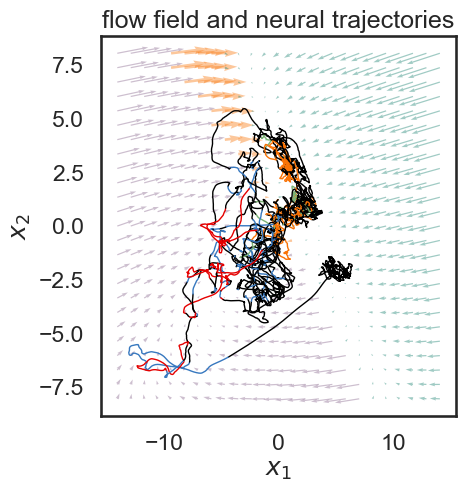

In [175]:
# Plot beh-defined trajectories on top of the flow-field
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
lim = abs(xhat_lem).max(axis=0) + 1
plot_most_likely_dynamics(rslds_lem, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), nxpts=25, nypts=25,ax=ax,alpha = 0.4)
plt.title("flow field and neural trajectories")

plot_trajectory_beh(statedatapy, xhat_lem,0,1,ax = ax)

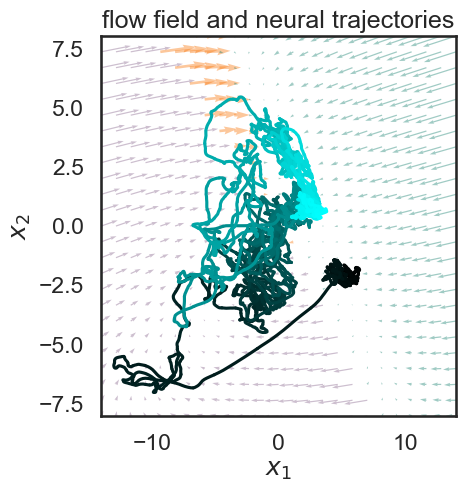

In [176]:
# Plot trajectories over time on top of the flow-field
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
lim = abs(xhat_lem).max(axis=0) + 1
plot_most_likely_dynamics(rslds_lem, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), nxpts=25, nypts=25,ax=ax,alpha = 0.4)
plt.title("flow field and neural trajectories")


# Prep data
n=len(xhat_lem)
x=xhat_lem[:,0]
y=xhat_lem[:,1]

# Your coloring array
T=np.linspace(0,1,np.size(x))


# Segment plot and color depending on T
s = 10 # Segment length
for i in range(0,n-s,s):
    ax.plot(x[i:i+s+1],y[i:i+s+1],color=(0.0,T[i],T[i]))
    ax.set_xlim([-lim[0], lim[0]])
    ax.set_ylim([-lim[1], lim[1]])
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')


### Model performance

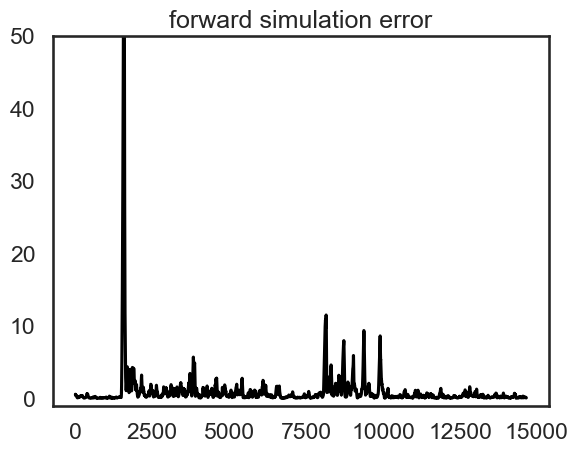

In [177]:
# Plot model performance on training data 
# forward simulation error
from sklearn.metrics import mean_squared_error

mse_all = []
startpoint = 1

for tini in range(startpoint, (len(xhat_lem)-100)):
    xinitial = xhat_lem[tini,:]
    pred_x = [xinitial]

    for t in range(tini,tini+100):
        state_id = zhat_lem[t]
        x_calc = pred_x[t-tini].dot(rslds_lem.dynamics.As[state_id,:,:].T) + rslds_lem.dynamics.bs[state_id,:]
        pred_x.append(x_calc)


    pred_x_arr = np.array(pred_x)
    real_x_arr = xhat_lem[tini:(tini+100+1),:]
    mse = mean_squared_error(real_x_arr, pred_x_arr)
    mse_all.append(mse)

mse_arr = np.array(mse_all)

plt.title("forward simulation error")
plt.plot(mse_arr,'k')
ax = plt.gca()
ax.set_ylim([-1, 50])

mdic = {"perf": mse_arr, "label": "Mouse_1"}
# savemat("~path/performance.mat", mdic)

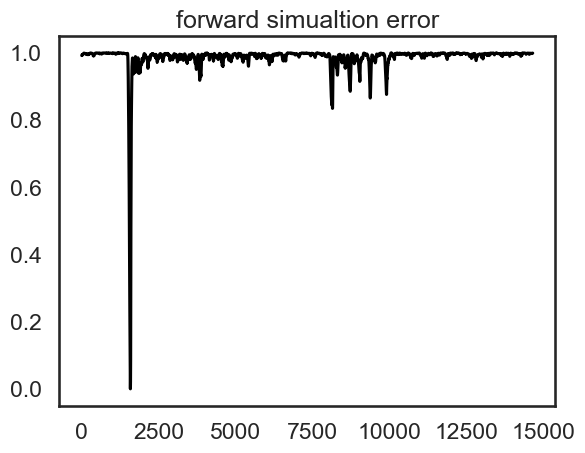

In [178]:
# plot normalized forward simulation error (as used in Liu, Nair et al.,)
mse_arr_norm = 1 - sklearn.preprocessing.minmax_scale(mse_arr, feature_range = (0,1))
plt.title("forward simualtion error")
plt.plot(mse_arr_norm,'k')
ax = plt.gca()
mdic = {"perf": mse_arr, "label": "Mouse_1"}
# plt.savefig("~path/model_performance.svg")

In [179]:
# Plot model performance on training data 
# predict neural trajectries forward in time

# calculate discrete states
startpoint = 1
xinitial = xhat_lem[startpoint,:]
pred_x = [xinitial]

for t in range(startpoint,len(xhat_lem)):
    z_calc = np.argmax(pred_x[t-startpoint].dot(rslds_lem.transitions.Rs.T) + rslds_lem.transitions.r, axis=0)
    x_calc = pred_x[t-startpoint].dot(rslds_lem.dynamics.As[z_calc,:,:].T) + rslds_lem.dynamics.bs[z_calc,:]
    pred_x.append(x_calc)
    
    
pred_x_arr_calc_state = np.array(pred_x)

In [180]:
# Plot model performance on training data 
# predict neural trajectries forward in time

# use given discrete states
startpoint = 1

xinitial = xhat_lem[startpoint,:]
pred_x = [xinitial]

for t in range(startpoint,len(xhat_lem)):
    state_id = zhat_lem[t]
    x_calc = pred_x[t-startpoint].dot(rslds_lem.dynamics.As[state_id,:,:].T) + rslds_lem.dynamics.bs[state_id,:]
    pred_x.append(x_calc)
    
pred_x_arr = np.array(pred_x)

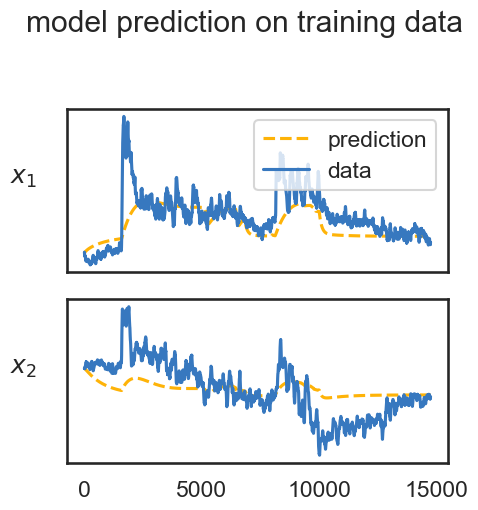

In [181]:
# Plot predicted continous states (latent factors) 
title_str = ["$x_1$", "$x_2$"]
fig, axs = plt.subplots(2,1, figsize=(5,5))
for (d, ax) in enumerate(axs):
    ax.plot( -pred_x_arr[:,d] + 4 * d, '--', color=colors[2], label="prediction" if d==0 else None)
    ax.plot( -xhat_lem[:,d] + 4 * d, '-', color=colors[1], label="data" if d==0 else None)

    ax.set_yticks([])
    ax.set_title(title_str[d], loc="left", y=0.5, x=-0.15)
axs[0].set_xticks([])
axs[0].legend(loc="upper right")

plt.suptitle("model prediction on training data", va="bottom")
plt.tight_layout()

# plt.savefig("~path/cont_states.svg")
# mdic = {"cont_states": xhat_lem, "label": "Mouse_2"}
# # savemat("~path/cont_states.mat", mdic)

<Axes: title={'center': 'Inferred Dynamics with flow field'}, xlabel='$x_1$', ylabel='$x_2$'>

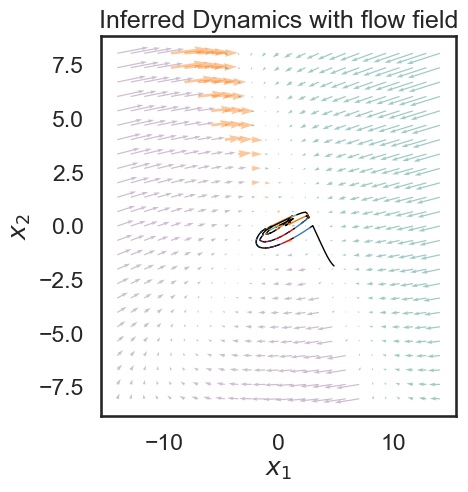

In [182]:
# show predicted trajectories in flow field
plt.figure(figsize=(5,5))
ax = plt.subplot(111)
lim = abs(xhat_lem).max(axis=0) + 1
plot_most_likely_dynamics(rslds_lem, xlim=(-lim[0], lim[0]), ylim=(-lim[1], lim[1]), nxpts=25, nypts=25,ax=ax,alpha = 0.4)
plt.title("Inferred Dynamics with flow field")

# plot_trajectory_beh(statedatapy, xhat_lem,0,1,ax = ax)
plot_trajectory_beh(statedatapy, pred_x_arr,0,1,ax = ax)


In [183]:
# Training R2 of model
from scipy import stats

resdim1 = stats.linregress(xhat_lem[:,0], pred_x_arr[:,0])
resdim2 = stats.linregress(xhat_lem[:,1], pred_x_arr[:,1])
resr2 = (resdim1.rvalue**2 + resdim2.rvalue**2)/2
resr2

0.46696563317752415

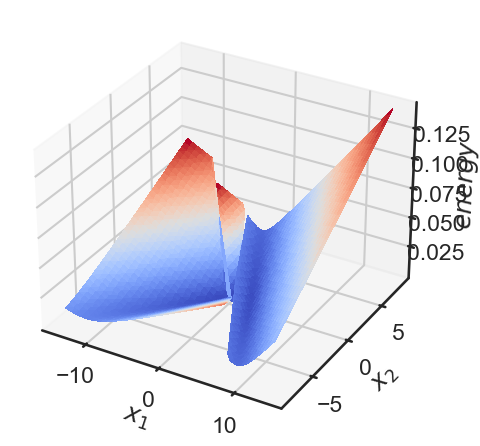

In [184]:
# Plot 3D dynamics velocity landscape
# %matplotlib qt
from matplotlib import cm

model = rslds_lem
xlim=(-lim[0], lim[0])
ylim=(-lim[1], lim[1])
nxpts=40
nypts=40
alpha=0.8
ax=None
figsize=(5, 5)

K = model.K
assert model.D == 2
x = np.linspace(*xlim, nxpts)
y = np.linspace(*ylim, nypts)
X, Y = np.meshgrid(x, y)
xy = np.column_stack((X.ravel(), Y.ravel()))

# Get the probability of each state at each xy location
z = np.argmax(xy.dot(model.transitions.Rs.T) + model.transitions.r, axis=1)

if ax is None:
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

model.dynamics.As = model.dynamics.As[:,:,:]
model.dynamics.bs = model.dynamics.bs[:,:]

for k, (A, b) in enumerate(zip(model.dynamics.As, model.dynamics.bs)):
#         dxydt_m = (xy**2).dot((A/2).T) + b - xy # plots energy
        dxydt_m = (xy).dot((A).T) + b - xy # plots dynamic velocity

        dxydt_m_norm = np.zeros((len(dxydt_m)))

        for xt in range(0,len(dxydt_m)): 
            dxydt_m_norm[xt] = np.linalg.norm(dxydt_m[xt,:])

        zk = z == k
        if zk.sum(0) > 0:

            ax.plot_trisurf(xy[zk, 0], xy[zk, 1], dxydt_m_norm[zk], cmap=cm.coolwarm,
                      linewidth=0, antialiased=False)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$energy$')

plt.tight_layout()